In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score
from sklearn.linear_model import LinearRegression

from IPython.display import clear_output

from scipy import sparse
from sklearn.metrics.pairwise import pairwise_distances, cosine_distances, cosine_similarity

In [2]:
# one-hot encodes a list of suggestions

def transform_sugg(sugg, encoder):
    return encoder.transform(np.array(sugg).reshape(-1,1))

In [3]:
rws = pd.read_csv('./movies_data/requests_with_suggestions.csv')

#split suggestion string into list - this must be done here because csv files do not store lists
rws['sugg_split'] = rws['suggestions'].str.split('%')

#count the number of suggestions
rws['sugg_count'] = rws['sugg_split'].apply(len)

#split scores string into list, then convert each digit into an integer with the applied lambda function
rws['scores'] = rws['scores'].str.split(',').apply(lambda s : [int(i) for i in s])

In [4]:
all_titles = []

for sugg_list in rws['sugg_split']:
    for sugg in sugg_list:
        if sugg not in all_titles:
            all_titles.append(sugg)
            
len(all_titles)

8887

In [5]:
ohe = OneHotEncoder()

all_titles_ohe = ohe.fit_transform(np.array(all_titles).reshape(-1,1))

rws['sugg_ohe'] = rws['sugg_split'].apply(transform_sugg, encoder = ohe)

rws = rws.fillna('')

In [405]:
train_df, test_df = train_test_split(rws, test_size = 0.2, random_state = 1701)

In [7]:
#Create a dataframe that will store documents, each document being the text for which a title was suggested

movie_col = []
text_col = []

titles_col = train_df['title'].astype(str)
selftext_col = train_df['selftext'].astype(str)

for i in train_df.index.values:
    sugg_list = train_df['suggestions'][i].split('%')
    text = titles_col[i] + ' ' + selftext_col[i]
    
    for sugg in sugg_list:
        movie_col.append(sugg)
        text_col.append(text)

sugg_text_df = pd.DataFrame([movie_col, text_col]).T
sugg_text_df = sugg_text_df.rename(columns = {0:'title_id', 1:'text'})
sugg_text_df = sugg_text_df.set_index('title_id')movie_col = []
text_col = []


In [8]:
# Create a dictionary that stores values of movie titles with keys of imdb title ids

movies = pd.read_csv('./movies_data/movies.csv')#.sort_values(by = 'year')

movies = movies[['id', 'primary_title', 'year']]

movies = movies[movies['id'].isin(sugg_text_df.index)] #https://stackoverflow.com/a/12098586

movies['year'] = movies['year'].astype(int)

movies = movies.sort_values(by = 'year')

title_dict = movies[['id', 'primary_title']].set_index('id').to_dict()['primary_title']

# Feature Optimization
----

The plan to evaluate the reccomendations is to compare test data to actual suggestions by the metric Recall
Recall only evaluates True Positives (movies suggested by both machine and humans) and False Negatives (movies suggested by humans but not by the machine)
This is ideal, becuase False Positives are not a big deal (and could, in fact, yield interesting results), and True Negatives make up the vast majority of the data.

Recall = TP / (TP + FN)

In a comparison of 20 recommendations, if the system predicts 5 of those titles, Recall = 5 / (5+ 15) = 0.25

To find a baseline for evaluation, the set of most recommended movies will be compared to the recommendations across all request documents. A "request document" is defined as the title + text of the recommendation, associated with a multilabel classification matrix of movie titles. This may be restricted to documents with reasonable number of suggestions (tenatively, 10 - 30), becuase as some requests saw nearly 1000 unique suggestions, the overlap between machine and human recommendations would become very large regardless of performance. Another approach would be to use comment scores to limit the suggestions to the top 20. The number 20 is chosen because that is approximately the average number of recommendations a request recieves.

To optimize features, recall will be measured, not with machine suggestions, but between the suggestions for each document and that document's most similar document in the corpus.


In [9]:
def vectorize_text(df, vectorizer, fit = True):
    #df should have 'id', 'title', and 'selftext' columns
    #function returns a dataframe with vectorized features, and the sparse matrix of features
    #the passed vectorizer is fit and can now transform other text, assuming it was initizialized outside of the function call
    
    doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)

    if fit:
        X_features = vectorizer.fit_transform(doc_text_df['documents'])
    else:
        X_features = vectorizer.transform(doc_text_df['documents'])

    doc_vectors_df = pd.DataFrame(X_features.toarray(), columns = vectorizer.get_feature_names(), index = doc_text_df.index)
    
    return doc_vectors_df, X_features

In [10]:
# returns a dictionary that maps each document to their most similar document(s) and their similarity score(s)
#   as a list of tuples like: (title_id, cosine_distance)

def get_similarity_dict(dist_df, size = 1):
    sim_dict = {tt_id : [] for tt_id in dist_df}
    
    for item in dist_df:
        try:
            most_similar = dist_df[item].sort_values()[1 : 1 + size]
        except:
            print(f"Problem with: {item}")
        for i in range(len(most_similar)):
            sim_dict[item].append((most_similar.index.values[i], most_similar.values[i]))
        
    return sim_dict

In [11]:
#Get a recall score for two sets of laebels + scores

def compare_labels(labels1, scores1, labels2, scores2, encoder, limits = [10, 20]):
    
    if len(labels1) == 0 or len(labels2) == 0:
        return 0.0
    
    labels1_df = pd.DataFrame(zip(labels1, scores1), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
    labels2_df = pd.DataFrame(zip(labels2, scores2), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
    
    #assign small and large on the assumption that 1 is large and 2 is small, check this assumption only if they aren't equal size
    large = labels1_df
    small = labels2_df
    
    # check if we need to select a limited portion of the passed labels before processing
    if len(labels1) != len(labels2) or len(labels1) not in range(limits[0], limits[1]+1):
        
        if len(labels1) < len(labels2):
            large = labels2_df
            small = labels1_df

        try:
            cutoff = large['score'][min(len(small), limits[1])]
        except:
            print(len(small))
        
        pared_large = large[large['score'] > cutoff]
        
        size = min(len(small), limits[1])
        
        difference = size - len(pared_large)
        
        while difference > 0:
            to_sample = difference
            
            if difference > len(large[large['score'] == cutoff]):
                to_sample = len(large[large['score'] == cutoff])
                
            pared_large = pared_large.append(large[large['score'] == cutoff].sample(to_sample))
            
            difference = size - len(pared_large)
            
            cutoff -= 1
            
            if cutoff < -1:
                break
        
        if(len(small)) > limits[1]:

            cutoff = small['score'][limits[1]-1]
            pared_small = small[small['score'] > cutoff]
            difference = limits[1] - len(pared_small)
        
            while difference > 0:
                to_sample = difference
            
                if difference > len(small[small['score'] == cutoff]):
                    to_sample = len(small[small['score'] == cutoff])

                pared_small = pared_small.append(small[small['score'] == cutoff].sample(to_sample))

                difference = limits[1] - len(pared_small)
                
                cutoff -= 1
                
                if cutoff < -1:
                    break
            
            small = pared_small
                
        large = pared_large
    
    # this is recall: cosine_similarity sum = True Positives, len(small) = all positives
    
    return cosine_similarity(transform_sugg(large['label'], encoder=encoder),
                        transform_sugg(small['label'], encoder=encoder)).sum() / len(small)

In [12]:
def get_recall_and_distance(df, similarity_dict, encoder, limits = [10,20], verbose = True, num_matches = 1):
# This function needs a dataframe and a similarity dictionary made with that dataframe
    count = 0

    np.random.seed(1701)

    recall_scores = []
    cos_distances = []

    for tt_id in df['id']:

        for i in range(num_matches):
            best_match = similarity_dict[tt_id][i][0]

            labels1 = df[df['id'] == tt_id]['sugg_split'].values[0]
            scores1 = df[df['id'] == tt_id]['scores'].values[0]

            labels2 = df[df['id'] == best_match]['sugg_split'].values[0]
            scores2 = df[df['id'] == best_match]['scores'].values[0]

            recall_scores.append(compare_labels(labels1, scores1, labels2, scores2, encoder = encoder, limits = limits))
            cos_distances.append(similarity_dict[tt_id][i][1])

        clear_output(wait = True)

        count += 1
        if count % 100 == 0:
            if verbose:
                print(f'{count} / {df.shape[0]}')
    
    if verbose:
        print(np.mean(recall_scores))
    
    return recall_scores, cos_distances

In [13]:
class Features_Evaluator:
    
    def __init__(self, df, vec, enc):
        self.df = df
        self.vectorizer = vec
        self.encoder = enc
        self.lr_fit = False
        
    def fit_vectorizer(self):
        doc_text_df = pd.DataFrame(zip(self.df['id'], self.df['title'] + self.df['selftext']),
                                   index = self.df['id'], columns = {0, 'documents'}).drop(columns = 0)
        self.vectorizer.fit(doc_text_df)
        
    def transform_with_vectorizer(self, test_df):
        df = test_df
        
        doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']),
                                   index = df['id'], columns = {0, 'documents'}).drop(columns = 0)
        
        X_features = self.vectorizer.transform(doc_text_df['documents'])
        
        return X_features
        
    
    def vectorize_text(self, fit = False):
        
        df = self.df
        vec = self.vectorizer
        
        doc_text_df = pd.DataFrame(zip(df['id'], df['title'] + df['selftext']), index = df['id'], columns = {0, 'documents'}).drop(columns = 0)

        if fit:
            X_features = vec.fit_transform(doc_text_df['documents'])
        else:
            try: 
                X_features = vec.transform(doc_text_df['documents'])
            except:
                print("Vectorizer is not fit. Use fit = True or call fit_vectorizer().")
                return

        doc_vectors_df = pd.DataFrame(X_features.toarray(), columns = vec.get_feature_names(), index = doc_text_df.index)
        
        cd_matrix = cosine_distances(X_features)

        doc_distance_df = pd.DataFrame(index = doc_vectors_df.index, columns = doc_vectors_df.index, data = cd_matrix)
        
        self.doc_vectors_df = doc_vectors_df
        self.doc_distance_df = doc_distance_df
        self.X_features = X_features
        
    def transform_sugg(self, sugg):
        return self.encoder.transform(np.array(sugg).reshape(-1,1))
    
    def make_similarity_dict(self, size = 1):
        dist_df = self.doc_distance_df
        
        sim_dict = {tt_id : [] for tt_id in dist_df}
        
        for item in dist_df:
            try:
                most_similar = dist_df[item].sort_values()[1 : 1 + size]
            except:
                print(f"Problem with: {item}")
            for i in range(len(most_similar)):
                sim_dict[item].append((most_similar.index.values[i], most_similar.values[i]))
        
        self.similarity_dict = sim_dict
        
    def get_similarity_dict(self):
        return self.similarity_dict
    
    def compare_labels(self, labels1, scores1, labels2, scores2, limits = [10, 20]):
        
        if len(labels1) == 0 or len(labels2) == 0:
            return 0.0
        
        labels1_df = pd.DataFrame(zip(labels1, scores1), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)
        labels2_df = pd.DataFrame(zip(labels2, scores2), columns = ['label', 'score']).sort_values(by = 'score', ascending = False)

        #assign small and large on the assumption that 1 is large and 2 is small, check this assumption only if they aren't equal size
        large = labels1_df
        small = labels2_df

        # check if we need to select a limited portion of the passed labels before processing
        if len(labels1) != len(labels2) or len(labels1) not in range(limits[0], limits[1]+1):

            if len(labels1) < len(labels2):
                large = labels2_df
                small = labels1_df

            try:
                cutoff = large['score'][min(len(small), limits[1])]
            except:
                print(len(small))

            pared_large = large[large['score'] > cutoff]

            size = min(len(small), limits[1])

            difference = size - len(pared_large)

            while difference > 0:
                to_sample = difference

                if difference > len(large[large['score'] == cutoff]):
                    to_sample = len(large[large['score'] == cutoff])

                pared_large = pared_large.append(large[large['score'] == cutoff].sample(to_sample))

                difference = size - len(pared_large)

                cutoff -= 1

                if cutoff < -1:
                    break

            if(len(small)) > limits[1]:

                cutoff = small['score'][limits[1]-1]
                pared_small = small[small['score'] > cutoff]
                difference = limits[1] - len(pared_small)

                while difference > 0:
                    to_sample = difference

                    if difference > len(small[small['score'] == cutoff]):
                        to_sample = len(small[small['score'] == cutoff])

                    pared_small = pared_small.append(small[small['score'] == cutoff].sample(to_sample))

                    difference = limits[1] - len(pared_small)

                    cutoff -= 1

                    if cutoff < -1:
                        break

                small = pared_small

            large = pared_large
        
        # this is recall: cosine_similarity sum = True Positives, len(small) = all positives
        
        return cosine_similarity(self.transform_sugg(large['label']),
                            self.transform_sugg(small['label'])).sum() / len(small)
    
    def get_recall_and_distance(self, limits = [10,20], verbose = True, num_matches = 1):
    # This function needs a dataframe and a similarity dictionary made with that dataframe
        count = 0
        
        df = self.df

        np.random.seed(1701)

        recall_scores = []
        cos_distances = []
        
        for tt_id in df['id']:

            for i in range(num_matches):
                best_match = self.similarity_dict[tt_id][i][0]

                labels1 = df[df['id'] == tt_id]['sugg_split'].values[0]
                scores1 = df[df['id'] == tt_id]['scores'].values[0]

                labels2 = df[df['id'] == best_match]['sugg_split'].values[0]
                scores2 = df[df['id'] == best_match]['scores'].values[0]

                recall_scores.append(self.compare_labels(labels1, scores1, labels2, scores2, limits = limits))
                cos_distances.append(self.similarity_dict[tt_id][i][1])

            

            count += 1
            if count % 100 == 0:
                if verbose:
                    clear_output(wait = True)
                    print(f'{count} / {df.shape[0]}')

        if verbose:
            print(f'Average recall: {np.mean(recall_scores)}')
        
        self.avg_recall = np.mean(recall_scores)
        self.avg_distance = np.mean(cos_distances)
        self.recall_scores = recall_scores
        self.cos_distances = cos_distances
        
    def linreg_recall(self):
        self.lr = LinearRegression()
        try:
            self.lr.fit(np.array(self.cos_distances).reshape(-1,1), self.recall_scores)
        except:
            print("Recall and Distances not calculated.")
            return
        self.slope = self.lr.coef_
        self.intercept = self.lr.intercept_
        self.pred1 = self.lr.predict(np.array(1).reshape(-1,1))
        self.lr_fit = True
        
        
    def print_lrstats(self):
        if self.lr_fit == False:
            self.linreg_recall()
        print(f'Slope:   {np.round(self.slope,4)}\nIntercept: {np.round(self.intercept, 4)}\nAt 1.0:   {np.round(self.pred1,4)}')
        
    def plot_recall_and_distance(self):
        if self.lr_fit == False:
            self.linreg_recall()
        
        fig = plt.figure(constrained_layout = True, figsize = (10,10))
        gs = gridspec.GridSpec(nrows = 3, ncols = 2, figure = fig)
        ax0 = fig.add_subplot(gs[0:2, 0:2])
        ax0.set_title("Recall Scores vs Cosine Distances", fontsize = 20)
        ax1 = fig.add_subplot(gs[2, 0])
        ax1.set_title("Cosine Distances", fontsize = 16)
        ax2 = fig.add_subplot(gs[2, 1])
        ax2.set_title("Recall Scores", fontsize = 16)

        x = np.linspace(0,1)
        ax0.plot(x, self.slope * x + self.intercept, color = 'gold', lw =3)
        ax0.scatter(self.cos_distances, self.recall_scores, alpha  = 0.07, color = 'seagreen')

        sns.distplot(self.cos_distances, ax = ax1, bins = 30, color = 'seagreen')
        sns.distplot(self.recall_scores, ax = ax2, bins = 30, color = 'seagreen');
        
    def process_df(self, dict_size = 1, num_matches = 1, label_limits = [10, 20], verbose = False):
        self.vectorize_text(fit = True)
        self.make_similarity_dict(size = dict_size)
        self.get_recall_and_distance(limits = label_limits, num_matches = num_matches, verbose = verbose)
        self.linreg_recall()

In [14]:
tf = TfidfVectorizer(max_features=5000, ngram_range=(1,3), stop_words='english')

doc_vectors_df, X = vectorize_text(rws, tf)

My ideal comparison size (for now) is in the range between 10 and 20. This provides a good number of suggestions without increasing the number so much that the comparison is meaningless. (For example, requests with 500 suggestions would have extremely high overlap, and likely have much in common with the list of 500 most suggested movies) Requests with > 20 suggestions will be pared down based on score.
This brings up a new problem: If a request has 30 suggestions, and 15 of them have score "1", and I am trying to compare to a 20-suggestion request, I will need to either:
- **A**) Limit the comparison to slices that *can* be compared accurately between 2 documents, or,
- **B**) Randomly sample the remaining suggestions to fill out the last 5 suggestions.

**A** is problematic because it will often not be possible to find any score cut-off that allows a direct comparison of top *x* suggestions between two requests. **B** is necessary because, although it is likely that suggestions are not ordered in any meaningful way, it is good to be certain that I am not optimizing for an unintentionally skewed distribution. The best solution could be to combine these: find the score cutoffs that allows the direct comparison which discards the least amount of information in my target range.

In [18]:
train_df10 = train_df[train_df['sugg_count'] >= 10]
test_df10 = test_df[test_df['sugg_count'] >= 10]


# Search through tfidf features on TRAINING DATA ONLY

In [19]:
tfidf_features = pd.DataFrame(columns = ['ngrams', 'max_features', 'max_df', 'min_df', 'avg_recall', 'avg_distance', 'intercept', 'pred1'])
tfidf_features = pd.read_csv('movies_data/tfidf_gridsearch_results.csv')
print(len(tfidf_features))

162


In [53]:
ngrams = [(3,3), (3,4), (3,5)]
max_features = [5000,7500,1000]
max_df = [0.01, 1.0]
min_df = [1]

iterations = len(ngrams) * len(max_features) * len(max_df) * len(min_df)
count = 0

for ng in ngrams:
    for mx_f in max_features:
        for mx_d in max_df:
            for mn_d in min_df:
                count +=1
                print(f'{count} / {iterations}')
                
                tf = TfidfVectorizer(ngram_range = ng, max_df = mx_d, min_df = mn_d, max_features=mx_f, stop_words='english')
                fe = Features_Evaluator(train_df, tf, ohe)
                fe.process_df()
                
                tfidf_features = tfidf_features.append({'max_df' : mx_d, 'max_features' : mx_f, 'min_df' : mn_d, 'ngrams' : ng,
                                       'avg_recall' : fe.avg_recall,
                                       'avg_distance' : fe.avg_distance,
                                       'intercept' : fe.intercept,
                                       'pred1' : fe.pred1}, ignore_index = True)

tfidf_features

1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18
18 / 18


,ngrams,max_features,max_df,min_df,avg_recall,avg_distance,intercept,pred1
0,"(1, 1)",1000,0.10,1.000,0.048891,0.529460,0.127078,[-0.02059501]
1,"(1, 1)",1000,0.10,0.005,0.045758,0.510569,0.121347,[-0.02670107]
2,"(1, 1)",1000,0.10,0.010,0.044712,0.420111,0.124190,[-0.06499373]
3,"(1, 1)",1000,0.30,1.000,0.049713,0.545726,0.134669,[-0.02100554]
4,"(1, 1)",1000,0.30,0.005,0.045647,0.528849,0.121042,[-0.02152322]
...,...,...,...,...,...,...,...,...
157,"(3, 5)",5000,1.00,1.000,0.058938,0.589661,0.182143,[-0.02679943960312023]
158,"(3, 5)",7500,0.01,1.000,0.058201,0.597429,0.179029,[-0.023218059081327513]
159,"(3, 5)",7500,1.00,1.000,0.058266,0.595541,0.178405,[-0.02332635952131565]
160,"(3, 5)",1000,0.01,1.000,0.086424,0.574475,0.221482,[-0.01361632891218495]


In [54]:
tfidf_features.to_csv('./movies_data/tfidf_gridsearch_results.csv', index = False)

In [64]:
tfidf_features[144:].groupby(by = 'min_df').mean()

,max_df,avg_recall,avg_distance,intercept
min_df,,,,
1,0.534615,0.058725,0.677225,0.167461


In [23]:
tfidf_features[144:].groupby(by = 'max_df').mean()

,max_features,min_df,avg_recall,avg_distance,intercept
max_df,,,,,
0.01,15000,1.0,0.049159,0.675763,0.160410
0.05,15000,1.0,0.048638,0.673206,0.157707
0.70,15000,1.0,0.048954,0.671413,0.161324
1.00,15000,1.0,0.048954,0.671413,0.161324


In [24]:
tfidf_features[144:].groupby(by = 'ngrams').mean()

,max_features,max_df,min_df,avg_recall,avg_distance,intercept
ngrams,,,,,,
"(2, 2)",15000,0.44,1.0,0.047195,0.700193,0.151928
"(2, 3)",15000,0.44,1.0,0.046733,0.670561,0.147861
"(3, 3)",15000,0.44,1.0,0.052850,0.648093,0.180786


In [25]:
tfidf_features[144:].groupby(by = 'max_features').mean()

,max_df,min_df,avg_recall,avg_distance,intercept
max_features,,,,,
10000,0.44,1.0,0.050546,0.652603,0.163866
15000,0.44,1.0,0.049259,0.675127,0.160983
20000,0.44,1.0,0.046973,0.691117,0.155725


In [27]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [44]:
model = ols(formula = "avg_recall ~ C(max_features)", data = tfidf_features[:81]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             avg_recall   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     3.248
Date:                Sat, 03 Oct 2020   Prob (F-statistic):             0.0442
Time:                        12:00:08   Log-Likelihood:                 280.37
No. Observations:                  81   AIC:                            -554.7
Df Residuals:                      78   BIC:                            -547.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0424      0.001     28.436      0.000       0.039       0.045
C(max_features)[T.5000]     0.0044      0.002      2.097      0.039       0.000       0.009
C(max_features)[T.8000]     0.0048      0.002      2.303      0.024       0.001       0.009
==============================================================================
Omnibus:                        9.898   Durbin-Watson:                   2.733
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                5.569
Skew:                           0.459   Prob(JB):                       0.0618
Kurtosis:                       2.101   Cond. No.                         3.73
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(max_features),2.0,0.000389,0.000195,3.247573,0.044183
Residual,78.0,0.004672,0.000060,NaN,NaN


-----

In [14]:
tf = TfidfVectorizer(max_features= 15000, max_df = 1.0, ngram_range = (1,1), stop_words='english')
fe = Features_Evaluator(train_df10, tf, ohe)

NameError: name 'train_df10' is not defined

In [490]:
fe.process_df(verbose = True)

3600 / 3657
Average recall: 0.05657448495708213


In [491]:
fe.avg_recall

0.05657448495708213

In [492]:
fe.print_lrstats()

Slope:   [-0.1526]
Intercept: 0.1603
At 1.0:   [0.0077]


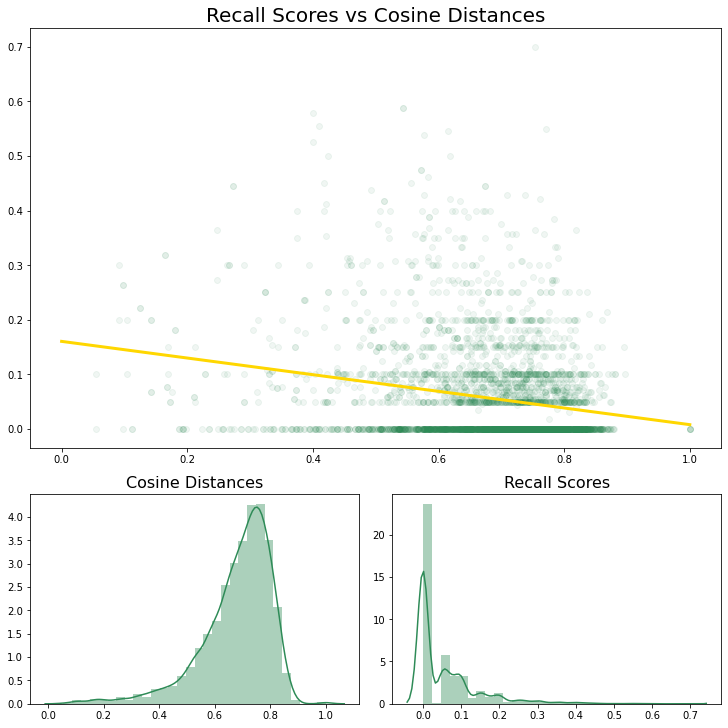

In [493]:
fe.plot_recall_and_distance()

---

In [462]:
titles_and_features

,00,000,00s,02,08,10,100,1000,10000,1000th,...,zoolander,zoology,zoomers,zooms,zorro,zucchini,zuckerberg,zulu,zzb9wo,östlund
title,,,,,,,,,,,,,,,,,,,,,
tt1734493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4263482,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0457430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt4846232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0443706,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt2543472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt3799694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt2494280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [494]:
X = fe.vectorizer.transform(sugg_text_df['text'])

titles_and_features = pd.DataFrame(X.toarray(), columns = fe.vectorizer.get_feature_names(), index = sugg_text_df.index)

titles_and_features = titles_and_features.groupby(by = 'title_id').mean()

titles_and_features

,000,10,10 000,10 10,10 cloverfield,10 minutes,10 movies,10 things,10 times,10 years,...,zombie,zombie apocalypse,zombie movie,zombie movies,zombieland,zombies,zone,zoo,zoomers,zorro
title_id,,,,,,,,,,,,,,,,,,,,,
tt0006864,0.0,0.066832,0.0,0.000000,0.0,0.0,0.054737,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0009968,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0010323,0.0,0.042106,0.0,0.026501,0.0,0.0,0.027282,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0011237,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt0012364,0.0,0.033914,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt9777644,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9779516,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tt9806192,0.0,0.039125,0.0,0.023018,0.0,0.0,0.003377,0.0,0.0,0.004251,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [495]:
def get_prediction(query_string):
    query_vec = tf.transform([query_string])
    query_df = pd.DataFrame(query_vec.toarray(), columns = tf.get_feature_names()).T
    
    features = query_df.loc[query_df[0] > 0].index.values

    rec_dict = {title : 0 for title in titles_and_features.index.values}
    
    #Find every potential match:

    for feat in features:
        title_vectors = titles_and_features[feat].sort_values(ascending = False)
        for i in title_vectors.index:
            rec_dict[i] += title_vectors[i]

    score_df = pd.DataFrame(rec_dict, index = ['score']).T
    
    #The df with potential matches:
    score_df = score_df.loc[score_df['score'] > 0].sort_values(by = 'score', ascending = False)
    #the vectors corresponding to the matched titles:
    labels_df = titles_and_features.T[score_df.index].T
    
    if len(labels_df) > 0:
    
        id_and_scores = zip(labels_df.index, cosine_similarity(X = labels_df, Y = query_df.T))

        ranking_dict = {}

        for tt_id, score in id_and_scores:
            ranking_dict[tt_id] = score

        final_df = pd.DataFrame(ranking_dict).T.rename(columns = {0 : 'score'}).sort_values(by = 'score', ascending = False)[:10]
    else:
        return [], [], pd.DataFrame(columns = ['score'])
    
    return final_df.index.values, np.arange(10,0,-1), final_df

In [496]:
def recall_row(test_df, n):
    row = test_df[n:n+1]
    query = row['title'].values[0] + row['selftext'].values[0]

    query_labels, label_scores, labels_df = get_prediction(query)

    true = row['sugg_split'].values[0]
    true_scores = row['scores'].values[0]
    return compare_labels(true, true_scores, query_labels, label_scores, encoder = ohe, limits = [0,len(query_labels)])

In [415]:
query_labels, label_scores, labels_df = get_prediction('I\'m looking for horror-crime movies that take place in a small town or village. A Detective or police is involved in resolving a crime which has both horror and crime elements. Doesn\'t matter if it\'s foreign, I like exploring different cultures.I prefer suspense over action and dislike cheap jump scares because they\'re mostly predictable. I\'m looking for something to keep me on the edge of my seat while sending chills down my spine.I also like monster movies but humans can be just as frightening in some cases.Good examples: The Wailing, Halloween (2018), I Saw the Devil, I See You')

# Find the average recall across all predictions

In [497]:
recall_sum = 0
found_matches = 0

for n in range(len(test_df)):
    recall = recall_row(test_df, n)
    recall_sum += recall
    if recall > 0:
        found_matches += 1
        
    clear_output(wait = True)
    print(f'{round(100 * n/len(test_df), 2)}%')
        
print(recall_sum / len(test_df))
print(found_matches)

99.94%
0.02813738652346255
288


In [498]:
found_matches / len(test_df)

0.16570771001150747

TFIDF Testing Recall:

Trial 1:

- ngramgs = 3,3
- features = 1000
- max_df = 0.01

- Training "recall" = 0.0845
- Testing recall = **0.0301**
- 15% of queries had match

Trial 2:

- ngrams = 1,1
- features = 15,000
- max_df = 1.0

- Training "recall" = 0.0597
- Testing recall = **0.0353**
- 20.1% of queries had match

Trial 3:

- ngrams = 1,2
- features = 8,000
- max_df = 0.1

- Training = 0.0566
- Testing  = **0.0281**
- 16.6% of queries had match

In [441]:
tfidf_features.sort_values(by = 'avg_recall', ascending = False)[:20]

,ngrams,max_features,max_df,min_df,avg_recall,avg_distance,intercept,pred1
160,"(3, 5)",1000,0.01,1.0,0.086424,0.574475,0.221482,[-0.01361633]
155,"(3, 4)",1000,1.00,1.0,0.084489,0.572490,0.215175,[-0.01310211]
148,"(3, 3)",1000,0.01,1.0,0.084486,0.576370,0.221874,[-0.01649355]
154,"(3, 4)",1000,0.01,1.0,0.084062,0.578304,0.218357,[-0.01386538]
161,"(3, 5)",1000,1.00,1.0,0.083737,0.571651,0.214059,[-0.0139147]
149,"(3, 3)",1000,1.00,1.0,0.082428,0.574006,0.215416,[-0.01626713]
89,"(1, 1)",15000,1.00,1.0,0.061908,0.696911,0.192790,[0.00498771]
83,"(1, 1)",5000,1.00,1.0,0.061288,0.653829,0.185852,[-0.00466304]
15,"(1, 1)",5000,1.00,1.0,0.061288,0.653829,0.185852,[-0.00466304]
85,"(1, 1)",10000,0.50,1.0,0.060915,0.688857,0.192963,[0.00127138]


In [500]:
train_df

,id,created_utc,title,selftext,suggestions,scores,sugg_split,sugg_count,sugg_ohe
3946,gikeq0,1589317548,Thriller Movies that take place in a House at ...,"The plot twist in Parasite, Identity ,",tt0340855%tt6378710,"[1, 1]","[tt0340855, tt6378710]",2,"(0, 4303)\t1.0\n (1, 8519)\t1.0"
6633,ej2eje,1577991384,What is your favorite “sexy” movie from the 90s?,,tt0109456%tt0110308%tt0120890%tt0169547%tt0139134,"[4, 2, 7, 7, 7]","[tt0109456, tt0110308, tt0120890, tt0169547, t...",5,"(0, 2586)\t1.0\n (1, 2628)\t1.0\n (2, 3282..."
4539,g3vdey,1587245087,Non-American comedy films with a different sen...,I'd like to see some non-American comedy films...,tt0092048%tt3011894%tt0080801%tt1465522%tt1512...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt0092048, tt3011894, tt0080801, tt1465522, t...",40,"(0, 1807)\t1.0\n (1, 7578)\t1.0\n (2, 1314..."
2218,hlemnq,1593913193,Movies where their memory is erased,"Like Bourne identity, memento or the long kiss...",tt0338013%tt0083658%tt0309698%tt1386703%tt0102...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[tt0338013, tt0083658, tt0309698, tt1386703, t...",15,"(0, 4278)\t1.0\n (1, 1417)\t1.0\n (2, 4125..."
282,ir7jj1,1599892112,Looking for movies where the main character is...,I recently watched Anna. I've watched Salt way...,tt5316540%tt1662557%tt3508840%tt7556122%tt0451...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt5316540, tt1662557, tt3508840, tt7556122, t...",72,"(0, 8291)\t1.0\n (1, 6584)\t1.0\n (2, 7763..."
...,...,...,...,...,...,...,...,...,...
3916,gjq9s4,1589475613,Looking for movies/shows specifically about sc...,I'll also accept shows and movies where this i...,tt1242460%tt0105327%tt2334896%tt6527426%tt1068...,"[1, 1, 2, 2, 1, 2, 2, 1, 1, 1]","[tt1242460, tt0105327, tt2334896, tt6527426, t...",10,"(0, 6014)\t1.0\n (1, 2408)\t1.0\n (2, 7238..."
5459,fkpkuq,1584538404,Movies that inadvertently predicted the future?,Do you know how The Simpsons unknowingly predi...,tt0097216,[1],[tt0097216],1,"(0, 2040)\t1.0"
5614,fgoib1,1583887667,Movies on Netflix,Looking for some hidden gem movies on Netflix....,tt1798709%tt2316411%tt4178092%tt1602613%tt4263...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt1798709, tt2316411, tt4178092, tt1602613, t...",18,"(0, 6760)\t1.0\n (1, 7216)\t1.0\n (2, 7980..."
5636,ffk8ap,1583705853,"Best ""inside a simulation"" movies?",I really like the Matrix and want something ki...,tt0109303%tt0120907,"[1, 1]","[tt0109303, tt0120907]",2,"(0, 2570)\t1.0\n (1, 3288)\t1.0"


In [487]:
for item in labels_df.index:
    print(title_dict[item])

Disturbing Behavior
Son in Law
Runaway Bride
Cookie's Fortune
Mumford
Universal Soldier
How to Make an American Quilt
Dante's Peak
Phantoms
Dream House


# CNN

In [42]:
# X_train = train_df text+titles vectorized (fit_transform)
# y_train = train_df sugg_ohe
# X_test = test_tf text+titles transformed
# y_test = test_df sugg_ohe

# But....should it be limited to top answers? top 20? 10? would have to re-do encoding for labels

In [17]:
tv = TfidfVectorizer(ngram_range=(1,2), max_features= 10_000, stop_words='english')
fe = Features_Evaluator(train_df, tv, ohe)

In [18]:
fe.vectorize_text(fit = True)

In [19]:
X_train = fe.X_features
X_test = fe.transform_with_vectorizer(test_df)

In [20]:
# Probably won't work.
y_train = train_df['sugg_ohe']
y_test = test_df['sugg_ohe']

In [21]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Flatten, Dense, MaxPool1D

In [108]:
model = Sequential()


#model.add(Conv1D(input_shape = (None, 1, X_train.shape[0]), filters = 2, kernel_size = 6, activation = 'relu', padding = 'same'))
model.add(Dense(1000, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(y_train[0].shape[1], activation = 'softmax'))

In [109]:
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['acc'])

In [25]:
X_train_rs = np.asarray(X_train.todense())
#X_train_rs = X_train_rs.reshape(X_train_rs.shape[0], X_train_rs.shape[1])
X_test_rs =  np.asarray(X_test.todense())
#X_test_rs = X_test_rs.reshape(X_test_rs.shape[0], X_test_rs.shape[1], 1)

In [100]:
#Probably going to have to make dense

X_train_rs.shape

(6948, 10000)

In [26]:
import numpy.linalg.linalg as la

In [27]:
import tensorflow as tf

In [28]:
y_train_dense = [list((la.dot(np.ones((1, y_train[n].shape[0])), y_train[n].todense())).A[0]) for n in y_train.index]

In [29]:
y_test_dense = [list((la.dot(np.ones((1, y_test[n].shape[0])), y_test[n].todense())).A[0]) for n in y_test.index]

In [41]:
#y_train_dense = tf.convert_to_tensor([(y_train[n].todense()) for n in y_train.index])

AttributeError: 'TfidfVectorizer' object has no attribute 'convert_to_tensor'

In [ ]:
#y_test_dense = tf.convert_to_tensor([(y_test[n].todense()) for n in y_test.index])

In [30]:
y_train_dense = np.asarray(y_train_dense)
y_test_dense = np.asarray(y_test_dense)

In [61]:
y_train_dense.shape

(6948, 8887)

In [62]:
y_test_dense.shape

(1738, 8887)

In [247]:
X_train_rs.reshape(-1, X_train_rs.shape[1], 1).shape

(6948, 10000, 1)

In [248]:
X_test_rs.reshape(-1, X_test_rs.shape[1], 1).shape

(1738, 10000, 1)

In [201]:
y_train_dense.shape

(6948, 8887)

In [202]:
y_test_dense.shape

(1738, 8887)

In [ ]:
X_

In [120]:
history = model.fit(X_train_rs,
                    y_train_dense,
                    batch_size=512,
                    validation_data=(X_test_rs, y_test_dense),
                    epochs=30)

Epoch 1/30
14/14 [==============================] - 3s 234ms/step - loss: 0.0162 - acc: 0.0272 - val_loss: 0.0196 - val_acc: 0.0058
Epoch 2/30
14/14 [==============================] - 3s 225ms/step - loss: 0.0162 - acc: 0.0282 - val_loss: 0.0197 - val_acc: 0.0075
Epoch 3/30
14/14 [==============================] - 3s 215ms/step - loss: 0.0161 - acc: 0.0284 - val_loss: 0.0197 - val_acc: 0.0081
Epoch 4/30
14/14 [==============================] - 3s 223ms/step - loss: 0.0161 - acc: 0.0298 - val_loss: 0.0197 - val_acc: 0.0052
Epoch 5/30
14/14 [==============================] - 3s 223ms/step - loss: 0.0161 - acc: 0.0289 - val_loss: 0.0197 - val_acc: 0.0046
Epoch 6/30
14/14 [==============================] - 3s 218ms/step - loss: 0.0160 - acc: 0.0296 - val_loss: 0.0198 - val_acc: 0.0040
Epoch 7/30
14/14 [==============================] - 3s 239ms/step - loss: 0.0160 - acc: 0.0320 - val_loss: 0.0198 - val_acc: 0.0046
Epoch 8/30
14/14 [==============================] - 3s 233ms/step - loss: 0.

In [121]:
preds = model.predict(X_test_rs[111:112])

In [122]:
preds

array([[1.6477053e-07, 2.4625774e-07, 2.0628307e-10, ..., 3.8068211e-07,
        2.1267043e-07, 1.4494836e-08]], dtype=float32)

In [123]:
test_df[111:112]

,id,created_utc,title,selftext,suggestions,scores,sugg_split,sugg_count,sugg_ohe
7866,d2anhi,1568135085,i need something actually funny to watch (it's...,drop your suggestions,tt1489887%tt3416742%tt0446029%tt1229340%tt0942...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[tt1489887, tt3416742, tt0446029, tt1229340, t...",27,"(0, 6345)\t1.0\n (1, 7732)\t1.0\n (2, 4940..."


In [124]:
pred_df = pd.DataFrame(zip(preds[0], movies['id'])).sort_values(by = 0, ascending = False)[:10]

In [125]:
pred_df.head()

,0,1
6226,0.045413,tt1773764
3342,0.029891,tt0137338
4916,0.025408,tt0385752
6316,0.020540,tt1596350
5376,0.018905,tt1092633


In [126]:
for tt in pred_df[1]:
    try:
        print(title_dict[tt])
    except:
        print(tt)

Ship of Theseus
200 Cigarettes
The Golden Compass
This Means War
The Goods: Live Hard, Sell Hard
Sidewalls
Lion
Wonderstruck
Metro Manila
Must Love Dogs


# gensim

In [330]:
from gensim import corpora
from gensim import models
from collections import defaultdict
from nltk.stem import PorterStemmer
from nltk.tokenize import NLTKWordTokenizer
from nltk.corpus import stopwords

In [285]:
documents = train_df['title'] + ' ' + train_df['selftext']

In [286]:
doc0 = documents[0]

In [400]:
def simplify_text(s):
    s = re.sub('[!,.:;\'\\u2019\\u0027]', '', re.sub('[^a-zA-Z0-9\'\\u2019]', ' ', re.sub('https://[=?\-_./\w]+', ' ', s)))
    return s

In [287]:
ps = PorterStemmer()
tok = NLTKWordTokenizer()

In [297]:
# tokenized_documents = []
# count = 0
# size = len(documents.index)

# for n in documents.index:
#     tokenized_documents.append([t for t in tok.tokenize(ps.stem(simplify_text(documents[n]))) if t not in stopwords.words()])
#     count +=1
#     clear_output(wait = True)
#     print(round(100* count/size,3))

100.0


In [299]:
# dictionary = corpora.Dictionary(tokenized_documents)
# dictionary.save('./movies_data/gensim_dictionary_requests.dict')

In [319]:
dictionary = corpora.Dictionary.load('./movies_data/gensim_dictionary_requests.dict')

In [320]:
dictionary.filter_extremes(keep_n = None)

In [327]:
corpus = [dictionary.doc2bow(text) for text in tokenized_documents]

In [331]:
tfidf = models.TfidfModel(corpus)

In [333]:
corpus_tfidf = tfidf[corpus]

In [335]:
corpus_tfidf[0]

[(0, 0.30862653767693116),
 (1, 0.40199367110922424),
 (2, 0.05766184958594592),
 (3, 0.24590010524226438),
 (4, 0.4445649632904978),
 (5, 0.31808689171775323),
 (6, 0.24843054371860018),
 (7, 0.23549438752520546),
 (8, 0.3156034563953015),
 (9, 0.22687409005897252),
 (10, 0.3350954858973296)]

In [354]:
d2v = models.doc2vec.Doc2Vec()

# spaCy

In [364]:
import spacy

In [356]:
nlp = spacy.load('en_core_web_lg')

In [406]:
train_df['document'] = train_df['title'] + ' ' + train_df['selftext']

train_df['document'] = train_df['document'].apply(simplify_text)

training_corpus = [nlp(doc) for doc in train_df['document']]

train_df['vector'] = [training_corpus[n].vector for n in range(len(train_df))]

In [423]:
movie_col = []
text_col = []
vector_col = []

titles_col = train_df['title'].astype(str)
selftext_col = train_df['selftext'].astype(str)

for i in train_df.index.values:
    sugg_list = train_df['suggestions'][i].split('%')
    text = titles_col[i] + ' ' + selftext_col[i]
    vector = train_df['vector'][i]
    
    for sugg in sugg_list:
        movie_col.append(sugg)
        text_col.append(text)
        vector_col.append(vector)

sugg_text_df = pd.DataFrame([movie_col, text_col, vector_col]).T
sugg_text_df = sugg_text_df.rename(columns = {0:'title_id', 1:'text', 2:'vector'})
sugg_text_df = sugg_text_df.set_index('title_id')

In [452]:
sugg_text_df.head(3)

,text,vector
title_id,,
tt0340855,Thriller Movies that take place in a House at ...,"[0.0369736, 0.13987559, -0.000101814214, -0.05..."
tt6378710,Thriller Movies that take place in a House at ...,"[0.0369736, 0.13987559, -0.000101814214, -0.05..."
tt0109456,What is your favorite “sexy” movie from the 90s?,"[-0.011213002, 0.05669349, -0.092942975, 0.064..."


In [531]:
# Mean vector of documents with movie as a suggestion
titles = sugg_text_df.index.unique()
vectors = [] # [np.mean(sugg_text_df.loc[x]['vector'].values, axis = 0) for x in titles]

count = 0

for x in titles:
    count +=1
    try:
        #This will fail if there is only one suggestion for a title
        vectors.append(np.mean(sugg_text_df.loc[x]['vector'].values, axis = 0))
    except:
        vectors.append(sugg_text_df.loc[x]['vector'])

In [535]:
titles_and_vectors = pd.DataFrame([titles, vectors]).T

In [541]:
titles_and_vectors = titles_and_vectors.rename(columns = {0:'title_id', 1:'vector'}).set_index('title_id')

In [542]:
titles_and_vectors

,vector
title_id,
tt0340855,"[-0.034197345, 0.099369794, -0.13456386, -0.08..."
tt6378710,"[-0.02854974, 0.12877923, -0.12792726, -0.0912..."
tt0109456,"[-0.025134487, 0.12722029, -0.1583227, -0.0394..."
tt0110308,"[-0.021729996, 0.07879962, -0.14822355, -0.068..."
tt0120890,"[-0.014220397, 0.09611716, -0.12849523, -0.058..."
...,...
tt1666335,"[-0.005817501, 0.10025365, -0.16165404, -0.128..."
tt0103596,"[-0.05681802, 0.0717111, -0.113699056, -0.0651..."
tt3832914,"[-0.1061105, -0.018027877, -0.11527701, -0.156..."


In [530]:
sugg_text_df.loc[titles[73]]['vector']

array([ 1.47486199e-02,  1.13514885e-01, -2.17135951e-01, -6.47403151e-02,
        7.27239400e-02,  3.69305424e-02, -1.50955562e-02, -1.41247034e-01,
        4.10594558e-03,  1.82963359e+00, -1.93555862e-01,  8.59100148e-02,
        1.22360088e-01, -1.16151974e-01, -6.39364123e-02, -1.86820235e-02,
       -5.01503758e-02,  9.59783316e-01, -2.18205869e-01, -3.66334915e-02,
        1.38040334e-02, -3.14156488e-02, -1.90010052e-02, -2.17895452e-02,
       -3.76533717e-02,  6.37797117e-02, -1.08085968e-01, -1.21840440e-01,
        7.07066804e-02, -7.24886060e-02, -2.13786978e-02,  6.71862215e-02,
       -2.52445657e-02,  7.41438419e-02,  6.10493645e-02, -4.48562093e-02,
        2.07135845e-02,  8.84433091e-02, -1.34191677e-01, -4.06984203e-02,
       -2.66388357e-02, -1.72333345e-02,  4.58459035e-02, -4.66529699e-03,
        3.05175260e-02,  1.25357851e-01, -1.37654796e-01, -5.19015484e-05,
        3.29269432e-02, -4.14532796e-02, -7.80482888e-02, -3.20225842e-02,
        1.14278169e-02, -

In [444]:
title_group = sugg_text_df[['vector']].groupby(by = 'title_id')

In [482]:
titles_sum_vectors = title_group.sum()

In [483]:
titles_sum_vectors

,vector
title_id,
tt0006864,"[-0.089959346, 1.0553827, -0.9949328, -0.96815..."
tt0009968,"[-0.37007248, 0.65111065, -0.71162164, -0.2137..."
tt0010323,"[-0.38086146, 2.109518, -2.821069, -1.9690285,..."
tt0011237,"[0.06325048, 0.16514876, -0.30314857, -0.23171..."
tt0012364,"[-0.20731035, 0.2897656, -0.4193489, -0.206517..."
...,...
tt9777644,"[-0.2457937, 1.2810187, -1.5450355, -0.8796804..."
tt9779516,"[-0.027808752, 0.29368925, -0.4845757, -0.2935..."
tt9806192,"[-0.38289985, 5.469204, -6.9470286, -4.1445165..."
